In [ ]:
import os
import pathlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the source and destination paths
source_folder_path = '/content/drive/MyDrive/SSD_MobileNet_V1_640x640'
destination_folder_path = '/content'

# Copy the folder from Google Drive to Colab
!cp -r "{source_folder_path}" "{destination_folder_path}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Clone and build Tensorflow Model

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (3080/3080), done.
remote: Total 4084 (delta 1186), reused 2884 (delta 944), pack-reused 0
Receiving objects: 100% (4084/4084), 44.61 MiB | 31.08 MiB/s, done.
Resolving deltas: 100% (1186/1186), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 75.4 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

# Helper Function

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.

  Args:
    eval_config: an eval config containing the keypoint edges

  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the source and destination paths
source_folder_path = '/content/drive/MyDrive/object-detection.pbtxt'
destination_folder_path = '/content'

# Copy the folder from Google Drive to Colab
!cp -r "{source_folder_path}" "{destination_folder_path}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/drive/MyDrive/object-detection.pbtxt': No such file or directory


# Model Pipeline

In [ ]:
#ssd_mobilenet_v1_fpn_640x640
pipeline_config = os.path.join('/content/drive/MyDrive/SSD_MobileNet_V1_640x640/saved_model/pipeline.config')
model_dir = '/content/drive/MyDrive/SSD_MobileNet_V1_640x640/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

# Inference

## Upload File

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Cheque083654.jpg to Cheque083654.jpg
User uploaded file "Cheque083654.jpg" with length 7778028 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
label_map_path = '/content/drive/MyDrive/object-detection.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


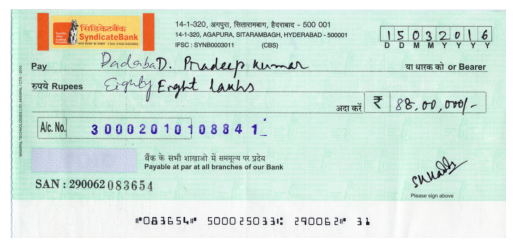

In [ ]:
image_dir = '/content/'
image_path = os.path.join(image_dir, list(uploaded.keys())[0])
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display the uploaded image using Matplotlib
plt.imshow(mpimg.imread(image_path))
plt.axis('off')  # Turn off axis
plt.show()


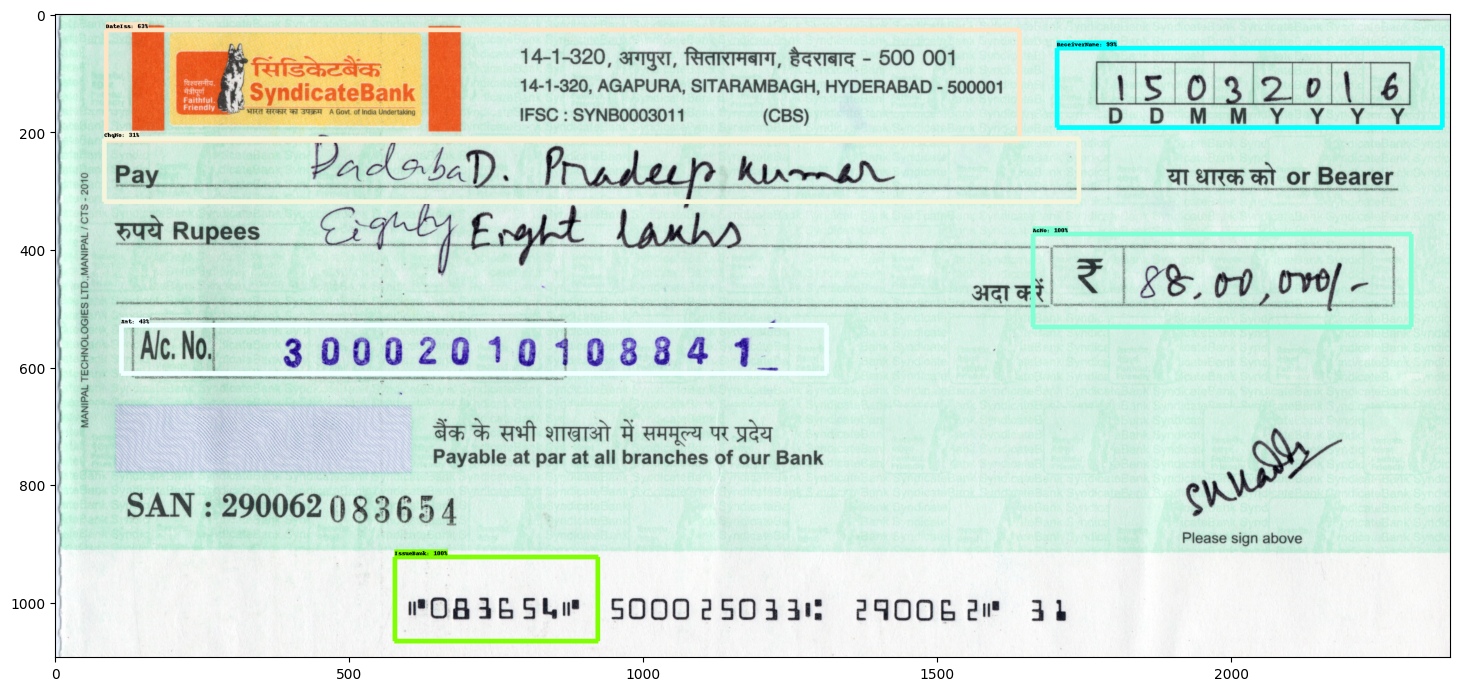

In [ ]:

image_dir = '/content/'
image_path = os.path.join(image_dir, list(uploaded.keys())[0])
image_np = load_image_into_numpy_array(image_path)
# Image to tensor
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      line_thickness=8,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(18,24))
plt.imshow(image_np_with_detections)
plt.savefig('prediction.jpg')
plt.show()


In [ ]:
detections['detection_boxes'][:,:6,:]

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[0.84501886, 0.24341977, 0.97489333, 0.38919508],
        [0.34284544, 0.7009723 , 0.48584247, 0.9725146 ],
        [0.05396968, 0.7179754 , 0.17649834, 0.9948971 ],
        [0.02554131, 0.03661424, 0.19643044, 0.6914434 ],
        [0.4848145 , 0.04722199, 0.55862176, 0.5532825 ],
        [0.19485411, 0.03510621, 0.29101568, 0.73404074]]], dtype=float32)>

In [ ]:
 (xminn, xmaxx, yminn, ymaxx) = (0.2413808 * 2365,  0.3857841* 2365,0.2413808  * 1100, 0.9515534  * 1100)


In [ ]:
print(xminn, xmaxx, yminn, ymaxx)

570.865592 912.3793965000001 265.51888 1046.70874
